<a href="https://colab.research.google.com/github/thomasmanke/ABS/blob/main/05_confounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we introduce confounding for discrete and continous data


# Libraries

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%script echo install if parallelization is necessary
%%R
#install.packages('mcreplicate')
#library(mcreplicate)

install if parallelization is necessary


# Simpson Paradox

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-simpsons-paradox.html

## Learning Objectives

- have a causal model (more than predictions)
- rationalize experimental design
- discriminate good and bad controls
- theory: DAG and causal inference
- tools: dagitty.net - simulations


## An Example

Let's assume we have observed the following data on the success $Y$ of a doctor (or a treatment) $X$.

- $X:$ Doctor $\in \{A, B\}$
- $Y:$ Outcome $\in \{+, -\}$

For numerical convenience, we can also encode all binary variables as $\{0, 1\}$ - this makes accessing the values in numpy arrays more convenient.

A typical data table would read like this



In [1]:
import numpy as np
import pandas as pd

d=np.array([17,20,83,80]).reshape(2,2) # define 2x2 array

rows=("-","+")
cols=("A","B")
df = pd.DataFrame(d, rows, cols)

# just some prettification
df_p = pd.DataFrame(
    df.values,
    pd.MultiIndex.from_product([['Outcome Y'], df.index]),
    pd.MultiIndex.from_product([['Treatment X'], df.columns])
)

# distributions
p = d / d.sum()     # joint prob. dist. p(X,Y)
p = df / df.sum()   # cond. prob. dist. p(Y|X=i), pd.sum() is column-wise!
print(df_p)
print(p.loc[["+"]]) # cond. prob. dist. p(Y="+"|X=i)

            Treatment X    
                      A   B
Outcome Y -          17  20
          +          83  80
      A    B
+  0.83  0.8


Doctor A seems more successful.

The asssignment ($X$=column, $Y$=row) is arbitrary, but I prefer to visualize $X$ horizontally and $Y$ vertically (in analogy to the typical continous representation)

Now a colleague points out that there is a potential confounding factor $Z$: the severity of the disease (difficulty of the treatment): band-air removal ($Z=0$) vs heart-operation ($Z=1$)

In [ ]:
# define 2x2x2 array
d=np.array((9,8,0,20, 81,2,10,70)).reshape(2,2,2)

def printSuccess(M):
  sr=M[1,:] / M.sum(axis=0)
  print('M:\n',M)
  print('success rate: {}\n '.format(sr))

printSuccess(d[...,0])
printSuccess(d[...,1])
printSuccess(d[...,0]+d[...,1])

M:
 [[ 9  0]
 [81 10]]
success rate: [0.9 1. ]
 
M:
 [[ 8 20]
 [ 2 70]]
success rate: [0.2        0.77777778]
 
M:
 [[17 20]
 [83 80]]
success rate: [0.83 0.8 ]
 


- Understanding the data
- Understanding the problem
- Understanding the tools / calculation
- Understanding the theoretical framework
- Making a recommendation

In [ ]:
import pandas as pd
d=np.random.binomial(n=1, p=0.5, size=[100,2])
df = pd.DataFrame(d, columns=['Treatment','Outcome'])
df.head().style

,Treatment,Outcome
0,1,1
1,1,1
2,0,1
3,1,0
4,1,1


Naturally, we would like to know which treatment (which doctor) has a higher success rate. 

Is there an association between $X$ and $Y$?



## Other Examples

- tax rate $Y$ decreases over time $X$ for each earning group $Z$, but increases when aggregated over all $Z$
- median income $Y$ decreases over $X$ for each education group $Z$, but increases on aggregate.
- acceptance rate $Y$, gender $X$, department $Z$
- saving rate $Y$, tool of transport $X$ (helicopter, car), severity of injury $Z$  

## Association Measures

In [ ]:
from scipy.stats.contingency import association, chi2_contingency
tab=pd.crosstab(index=df['Treatment'], columns=df['Outcome'], margins=True)
print(tab)

chi2, pv, dof, exp = chi2_contingency(tab)
ass=association(tab, method="pearson")
print(chi2, ass, pv)

Outcome     0   1  All
Treatment             
0          29  32   61
1          14  25   39
All        43  57  100
1.3158966607207876 0.05726215799135208 0.858672713811381


Of course there is no association in this simulated sample, but how about a "real" one

In [ ]:
import numpy as np
d = np.array([17, 83, 20, 80])
d = d.reshape(2,2)
tab=pd.DataFrame(d) 
print(tab)
chi2, pv, dof, exp = chi2_contingency(d)

print(chi2, pv)


    0   1
0  17  83
1  20  80
0.1326479854087216 0.715702162380897


Also not very strong.

## Conditional Distributions

In [ ]:
# The data summary as 2x2x2 table
d=np.array([6, 81, 71, 192, 36, 234, 25, 55])

# define empirical multinomial probability distribution
p = d / d.sum() 

# reshape d into array (2x2x2 table) for easier interpretation
d=d.reshape(2,2,2) 

## Messages

- confounders (here: severity) may have confusing consequences
- "paradox": mathematical triviality, but unintuitive (causal thinking vs statistical thinking)
- data alone does not know the causal (scientific) model
- understanding the problem, but what should be the recommendation
- we need a language to relate statistical models (observation) to causal models (interventions)
- measure all things -> control all things -> model all things
- Prediction (Accuracy) $\ne$ Understanding (consequence of action)
- Can be extended from binary to categorical to continous variables.

# To Condition or Not To Condition

# To Do or Not To Do

##References

- Brady Neal, Causal Inference: https://www.youtube.com/watch?v=zeuW1Z2EtLs
  - https://www.bradyneal.com/causal-inference-course
- Joseph Blitzstein (Harvard): https://www.youtube.com/watch?v=fDcjhAKuhqQ
- A Crash Course on Good and Bad Controls: https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf

# Confounding

Multiple Regression

- account for confounds (can hide or reverse associations)
- account for multiple causation
- account for interactions

# Multivariate posteriors

- Predictor residual plots
- Counterfactual plots
- Posterior Predictive Plots

# The Fork: $X \longleftarrow Z \longrightarrow Y$

Let's assume the following research question:
Are $X$ and $Y$ causally related?

The fork is a classical confounder that can cause spurious correlations between two variable $X$ and $Y$ if they are both controlled by a confounding variable $Z$. 

Below are examples for various discrete, continuous and mixed cases.

## Binary $X,Y,Z$

In [ ]:
%%R
N=1000
set.seed(42)

# Bernoulli = Binomial(size=1)
Z=rbinom(N,size=1, prob=0.5)                # prob=0.5
X=rbinom(N,size=1, prob=(1-Z)*0.1 + Z*0.9)  # prob={0.1,0.9}
Y=rbinom(N,size=1, prob=(1-Z)*0.1 + Z*0.9)  # prob={0.1,0.9}

print(table(X,Y))
# correlation for binary variables is strong simplification
# better use chisq.test(table)$statistics
cat('X~Y:', cor(X,Y),'\n')
cat('X~Y|Z=0:', cor(X[Z==0],Y[Z==0]), '\n') # stratification Z=0: no correlation
cat('X~Y|Z=1:', cor(X[Z==1],Y[Z==1]), '\n') # stratification Z=1: no correlation

   Y
X     0   1
  0 429  88
  1  91 392
X~Y: 0.641524 
X~Y|Z=0: 0.04350393 
X~Y|Z=1: 0.007791429 


**Message**:

$X$ and $Y$ are causally unrelated (here by design), but appear correlated because of a common confounder ($Z$). Conditioning on the confounder (stratification) removes this spurious association (correlation).

## Binary $Z$, Normal $X,Y$

X~Y: 0.4855193 
X~Y|Z=0: -0.06035547 
X~Y|Z=1: -0.03758264 


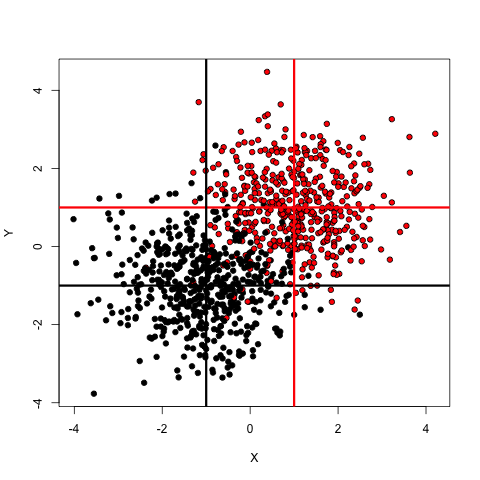

In [ ]:
%%R
N=1000 
set.seed(42)
Z=rbinom(N,size=1, prob=0.5) 
X=rnorm(N,mean=2*Z-1)          # mean={-1,1}
Y=rnorm(N,mean=2*Z-1)
plot(X,Y, bg=Z+1, pch=21)
abline(h=c(-1,1), col=c(1,2), lwd=3)  # plot mean y
abline(v=c(-1,1), col=c(1,2), lwd=3)  # plot mean y

cat('X~Y:', cor(X,Y),'\n')
cat('X~Y|Z=0:', cor(X[Z==0],Y[Z==0]), '\n') # stratification Z=0: no correlation
cat('X~Y|Z=1:', cor(X[Z==1],Y[Z==1]), '\n') # stratification Z=1: no correlation

## Normal $X,Y,Z$

For continuous variables, "stratification" is done by regression:
Account for $Z$ and see if there is still an association between $X$ and $Y$ 

**Example Question:**

How does Rate of Marriage ($X$) effect Rate of Divorce ($Y$) when accounting for Age of Marriage ($Z$)


### Correlation Plots and Pairwise Regressions

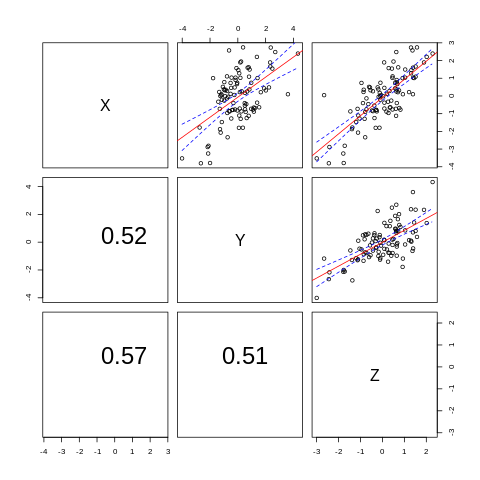

In [ ]:
%%R
# define fork: X <- Z -> Y
N=100   
set.seed(42)
Z=rnorm(N)
X=rnorm(N,mean=Z)
Y=rnorm(N,mean=Z)
df=data.frame(X=X, Y=Y, Z=Z)

# define convenience functions
pw_fit = function(x,y){
    model = lm(y~x)
    newx = data.frame(x=seq(min(x),max(x),by = 0.05))
    CI <- predict(model, newdata=newx, interval="confidence",level = 0.95)
    points(x,y)
    abline(model, col='red')
    lines(newx$x, CI[,2], col="blue", lty=2)
    lines(newx$x, CI[,3], col="blue", lty=2)
}

# pairwise correlation coeff
pw_cor <- function(x, y) { text(0.5, 0.5, round(cor(x,y),2), cex=3) }

# pairwise regression coefficients
pw_reg <- function(x, y) { text(0.5, 0.5, round(lm(y~x)$coefficients['x'],2), cex=3) }

pairs(df, panel=pw_fit, lower.panel=pw_reg)

### Confidence Intervals from Multi-variate regressions

In [ ]:
%%R
model1 = lm(Y~X)           # wrong causal effect of X on Y
print(confint(model1))

model2 = lm(Y~X+Z)         # true causal effec of X on Y (here: 0)
print(confint(model2))

                 2.5 %    97.5 %
(Intercept) -0.1745003 0.2763200
X            0.3616054 0.6849198
                 2.5 %    97.5 %
(Intercept) -0.2004792 0.2040118
X           -0.1384363 0.3090227
Z            0.4701498 1.0718453


### A more graphical summary

... again focus on confidence intervals but with a more graphical summary. 

For other ways of fitting refer to 05_fitting.pynb (especially for the Bayesian treatment).

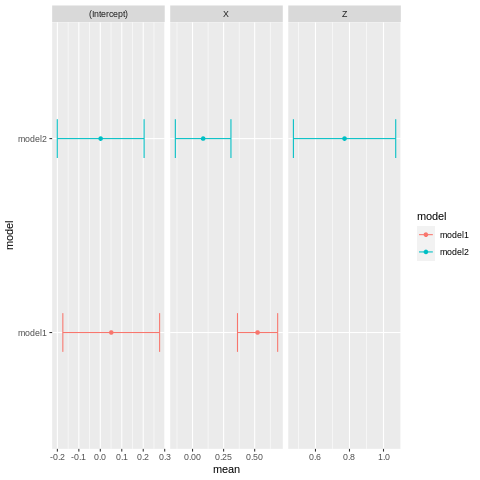

In [ ]:
%%R 
library(dplyr)
library(ggplot2)
getCI = function(model, conf_level=0.95, mn = deparse(substitute(model))){ 
  # build tibble for confidence interval of model parameters
  CI = confint(model, level=conf_level) %>% 
    as_tibble(rownames="parm") %>% 
    mutate(mean=coef(model)) %>% 
    mutate(model=mn)
  
  # variable names `2.5  %` and `97.5 %` are hard to pass to ggplot
  colnames(CI)[2:3]=c("lower","upper")
  return(CI)
}

plotCIP = function(CIP){
  # plot a dataframe CIP of parameter estimates and der confidence interval
  # CIP colums: parm_name, lower, upper, mean, model_name
  ggplot(CIP, aes(x=model, y=mean, ymin=lower, ymax=upper, col=model)) + 
    geom_point(position = position_dodge(0.8)) + 
    geom_errorbar(width=0.2, size=0.5, position = position_dodge(0.8),) + 
    coord_flip() +
    facet_wrap(~parm, scales="free_x")
}

CIP1 = getCI(model1)
CIP2 = getCI(model2)
plotCIP(rbind(CIP1,CIP2))

### Messages

1. association of X with Y is spurious. It
disappears when stratifying for Z
2. Confounding factors **(forks)** can be controlled by stratification
3. start from scientific model to define causal graph

# Collider: $X \longrightarrow Z \longleftarrow Y$

                 2.5 %     97.5 %
(Intercept) -0.2687107 0.09197713
X           -0.1468093 0.20112765
                 2.5 %     97.5 %
(Intercept) -0.1759176  0.0839540
X           -0.5213148 -0.2219905
Z            0.3574285  0.5430614


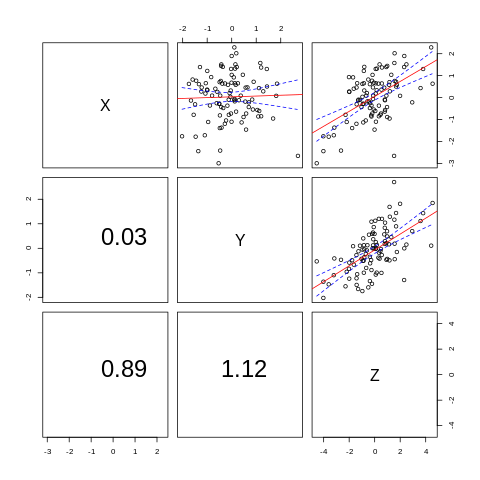

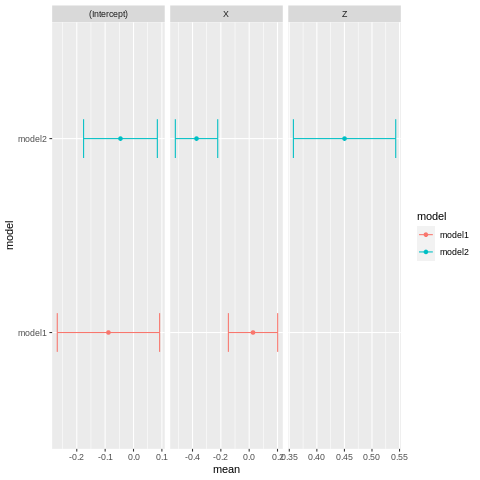

In [ ]:
%%R
# define collider: X -> Z <- Y
N=100   
set.seed(42)
X=rnorm(N)
Y=rnorm(N)
Z=rnorm(N, mean=X+Y)
df=data.frame(X=X, Y=Y, Z=Z)
pairs(df, panel=pw_fit, lower.panel=pw_reg)

model1 = lm(Y~X)
print(confint(model1))

model2 = lm(Y~X+Z)
print(confint(model2))
CIP1 = getCI(model1)
CIP2 = getCI(model2)
plotCIP(rbind(CIP1,CIP2))

### Messages

1. there is no association of $X$ with $Y$ is spurious. It appears when stratifying for $Z$
2. Stratication **(collider)** may introduce confounding and biases
3. start from scientific model to define causal graph


# Multi-Colinearity



Colinearity can arise if multiple predictor variables $X_i$ are strongly associated/correlated with each other. In this case only combinations of parameters might be identifiable, but individual predictive contributions to $Y$ can be highly uncertain.

b1: 0.9835697 
b2: 0.4471654

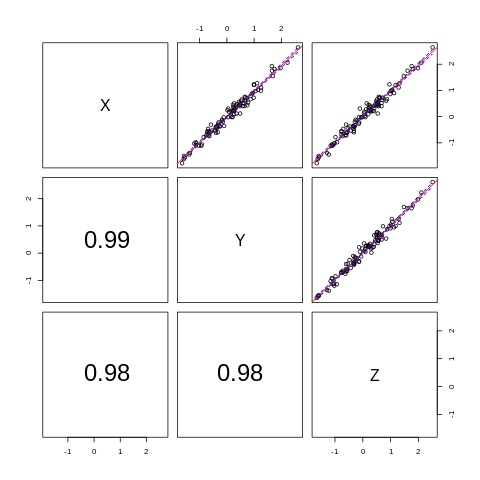

In [ ]:
%%R
# here X1 and X2 have a common (but unknown) cause u
# c.f X -> Z -> Y (pipe)
N=100
u  = rnorm(N)
X1 = rnorm(N, mean=u, sd=0.1)
X2 = rnorm(N, mean=u, sd=0.1)
Y  = rnorm(N, mean=u, sd=0.1)
b1=coef(lm(Y ~ X1))['X1']
b2=coef(lm(Y ~ X1 + X2))['X1']

cat('b1:', b1, "\n")
cat('b2:', b2)
df=data.frame(X=X1, Y=X2, Z=Y)
pairs(df, panel=pw_fit, lower.panel=pw_reg)

**Examples**:

- Both right and left leg length are good predictors of human height - but the coefficients become very uncertain when used together

- both lactose level and fat level are good predictors of milk energy - but they are highly anti-correlated. When used in the same regression model, their individual regression coefficients will vary largely and have high uncertainty (but the regression coefficients will also be anti-correlated)

# Summary

Causal insights from regression $Y \propto X + Z$

- **do include** common cause variables (confounders)
- **do not include** mediators (block indirect causal effect on outcome)

To make this decision we do need a causal model!!!

# Dagitty

In [ ]:
%%R
install.packages('dagitty')
library(dagitty)

adjustmentSets (total):  u 
adjustmentSets (direct): c("Z", "u") 


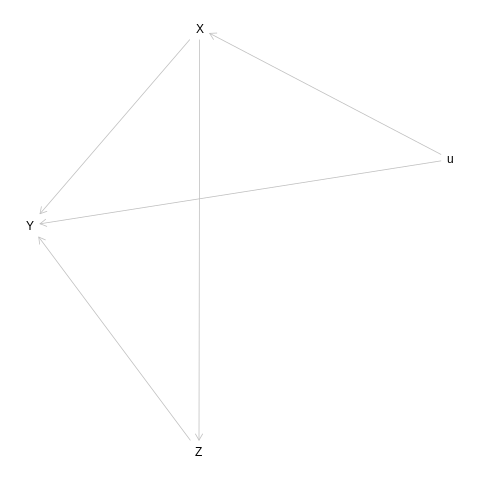

In [ ]:
%%R
# Example of haunted DAG (Rethinking, Ch6)
dag = dagitty( "dag{
    X -> Z -> Y
    X -> Y
    X <- u -> Y  
}")

plot(graphLayout(dag))
AS_t = adjustmentSets( dag, "X", "Y", effect="total" )
AS_d = adjustmentSets( dag, "X", "Y", effect="direct" )
cat(sprintf("adjustmentSets (total):  %s", AS_t ), "\n")
cat(sprintf("adjustmentSets (direct): %s", AS_d ), "\n")

In [ ]:
%%R
adjustmentSets( dag, "X", "Y", effect= "direct" )

{ Z, u }


# Tidyverse

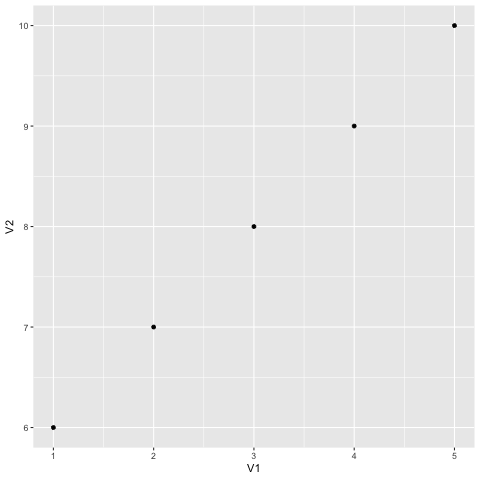

In [ ]:
%%R
library(tidyverse)
M=seq(1:10)
dim(M)=c(5,2)
as_tibble(M) %>% ggplot(aes(x=V1,y=V2)) + geom_point()